In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import usage_data.prepare_energy_data as energy
import helpers
import plan_data


In [2]:
# Read the energy usage/generation data and graph each of the generation and consumption data in two ways:
# 1) grouped by month, a heatmap of average hourly values
# 2) grouped by day of the week, three heatmaps: hourly consumption, hourly generation, hourly net.
#    The net is the difference between generation and consumption (for a given hour).

# Load the energy data
gen_data, cons_data = energy.load_energy_data('energy_data.csv')

# With the data loaded, we can now plot the data as described above
# Group by month and hour for heatmap
gen_data_hourly = energy.prepare_df(gen_data)
cons_data_hourly = energy.prepare_df(cons_data)


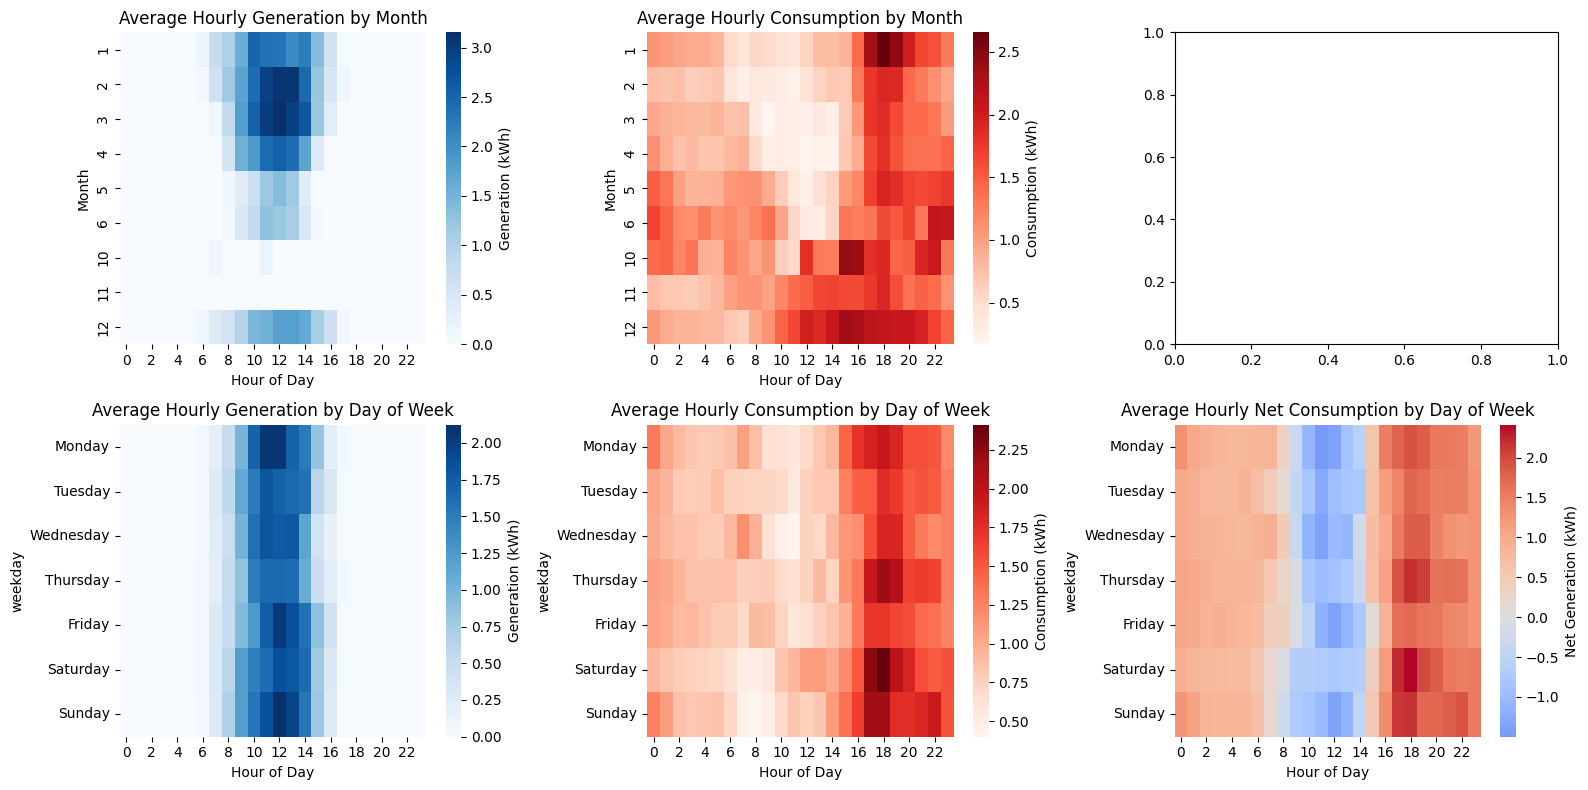

In [177]:
# With the summed data, we can now group by month and average each of the 24 hourly columns in the month to create the heatmap
gen_heatmap = gen_data_hourly.drop(columns=['Date/Time','date', 'dayofweek']).groupby('month').mean()
cons_heatmap = cons_data_hourly.drop(columns=['Date/Time','date', 'dayofweek']).groupby('month').mean()

# With the summed data, we can now group by day of the week and average each of the 24 hourly columns in the week to create the heatmap
gen_heatmap_dayofweek = gen_data_hourly.drop(columns=['Date/Time','date', 'month']).groupby('dayofweek').mean()
cons_heatmap_dayofweek = cons_data_hourly.drop(columns=['Date/Time','date', 'month']).groupby('dayofweek').mean()

# map day of week from int to day name
gen_heatmap_dayofweek = helpers.map_df_day_to_name(gen_heatmap_dayofweek) 
cons_heatmap_dayofweek = helpers.map_df_day_to_name(cons_heatmap_dayofweek)

# Calculate the net generation by subtracting consumption from generation (but only the hourly columns, not the series)
net_heatmap_dayofweek =  cons_heatmap_dayofweek - gen_heatmap_dayofweek


# Plot the data
fig, ax = plt.subplots(2, 3, figsize=(16, 8))

sns.heatmap(gen_heatmap, ax=ax[0, 0], cmap='Blues', cbar_kws={'label': 'Generation (kWh)'})
ax[0, 0].set_title('Average Hourly Generation by Month')
ax[0, 0].set_xlabel('Hour of Day')
ax[0, 0].set_ylabel('Month')

sns.heatmap(cons_heatmap, ax=ax[0, 1], cmap='Reds', cbar_kws={'label': 'Consumption (kWh)'})
ax[0, 1].set_title('Average Hourly Consumption by Month')
ax[0, 1].set_xlabel('Hour of Day')
ax[0, 1].set_ylabel('Month')


sns.heatmap(gen_heatmap_dayofweek, ax=ax[1, 0], cmap='Blues', cbar_kws={'label': 'Generation (kWh)'})
ax[1, 0].set_title('Average Hourly Generation by Day of Week')

sns.heatmap(cons_heatmap_dayofweek, ax=ax[1, 1], cmap='Reds', cbar_kws={'label': 'Consumption (kWh)'})
ax[1, 1].set_title('Average Hourly Consumption by Day of Week')

sns.heatmap(net_heatmap_dayofweek, ax=ax[1, 2], cmap='coolwarm', center=0, cbar_kws={'label': 'Net Generation (kWh)'})
ax[1, 2].set_title('Average Hourly Net Consumption by Day of Week')

ax[1, 0].set_xlabel('Hour of Day')
ax[1, 1].set_xlabel('Hour of Day')
ax[1, 2].set_xlabel('Hour of Day')

plt.tight_layout()
plt.show()


Max Net Consumption: 9.469999999999999 kWh
Max Net Generation: 8.379000000000001 kWh


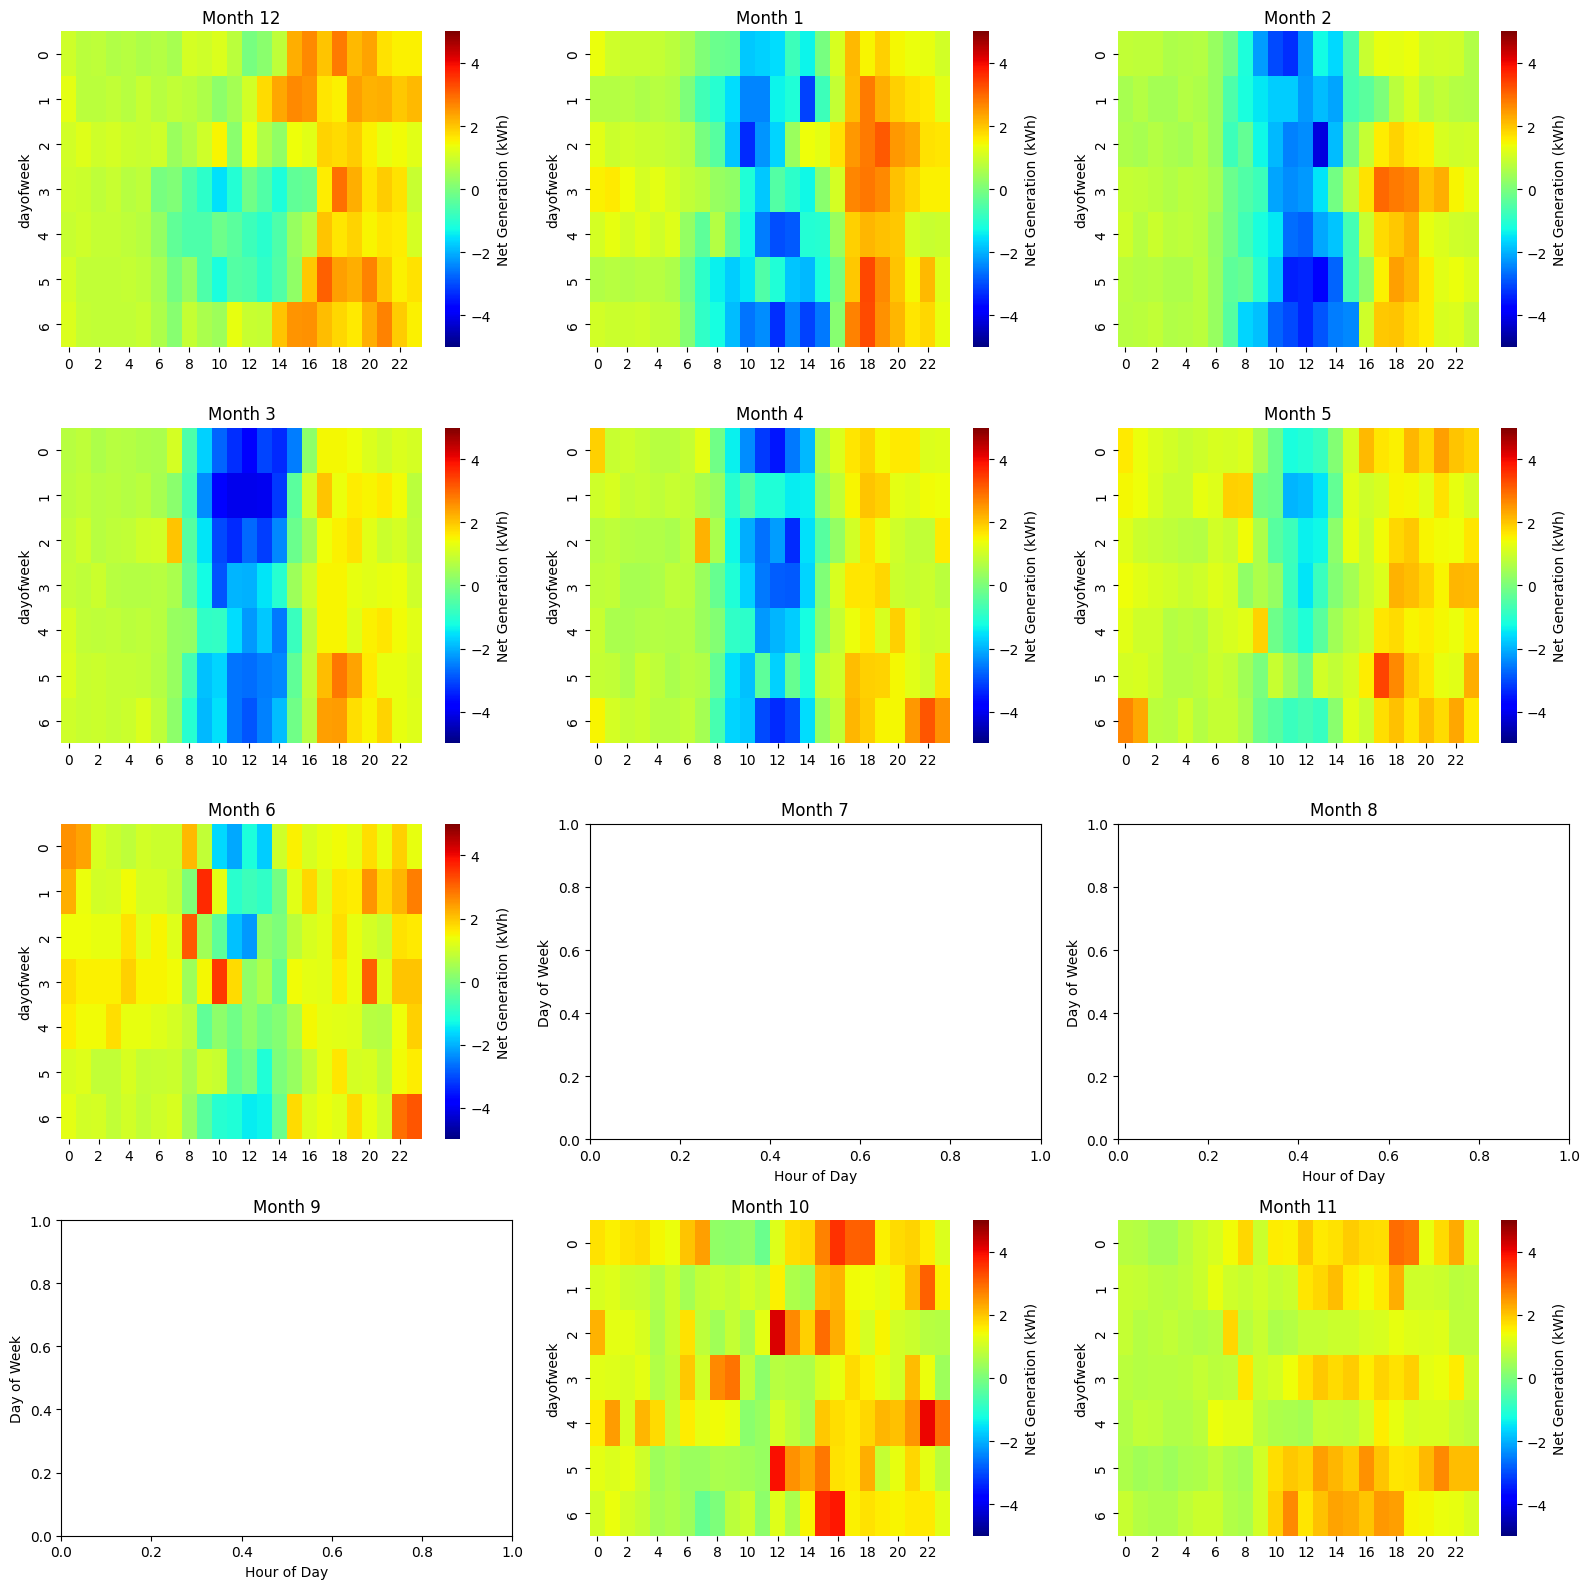

In [178]:
# subtract the values in the generation dataframe from the consumption dataframe to get the net consumption. we want to keep all the columns (but no maths on the date-related columns)

# Selecting only numeric columns (by data type or by column name pattern if consistent)
meta_cols = ['dayofweek', 'month', 'date', 'Date/Time']
numeric_cols = cons_data_hourly.columns.difference(meta_cols)

# Subtract the numeric columns of df2 from df1
net_data = (cons_data_hourly[numeric_cols] - gen_data_hourly[numeric_cols])

max_val = net_data.max().max()
min_val = net_data.min().min()

print(f'Max Net Consumption: {max_val} kWh')
print(f'Max Net Generation: {min_val * -1} kWh')

net_data = net_data[sorted(net_data.columns, key=int)]
net_data = net_data.join(cons_data_hourly[meta_cols])

monthly_data = {
    month: net_data[net_data['month'] == month].drop(columns=['Date/Time', 'date', 'month'])
    .groupby(['dayofweek']).mean()
    for month in range(1, 13)
}

# Plot the data in a 3x4 grid of heatmaps, each row in the grid is a season (Dec-Feb, Mar-May, Jun-Aug, Sep-Nov)
fig, ax = plt.subplots(4, 3, figsize=(16, 16))

plt.title('Average Hourly Net Generation by Day of Week for Each Month')


# Define a season map where keys are month indices (1-12) and values are (row, col) tuples
seasons = [
    (12,1,2),
    (3,4,5),
    (6,7,8),
    (9,10,11)
]

# Dictionary to hold month to (row, col) mappings
season_map = {}
for row, months in enumerate(seasons):
    for col, month in enumerate(months):
        season_map[month] = (row, col)


for month, data in monthly_data.items():

    row, col = season_map[month]

    subplot = ax[row, col]

    subplot.set_title(f'Month {month}')

    subplot.set_xlabel('Hour of Day')
    subplot.set_ylabel('Day of Week')

    if data.empty: continue
    sns.heatmap(data, ax=subplot, cmap='jet', vmax=5, vmin=-5, center=0, cbar_kws={'label': 'Net Generation (kWh)'})

plt.tight_layout()
plt.show()



In [69]:
# solar_df, tarrif_df, supply_charge = plan_data.load_rate_plan('plan_data.json')
# solar_df, tarrif_df, supply_charge = plan_data.load_rate_plan('PSH709135MRE1-2154-details.json')
solar_df, tarrif_df, supply_charge = plan_data.load_rate_plan('GLO736344MRE1-2154-details.json')


Solar Feed-in Tariff DataFrame:
     0    1    2    3    4    5    6    7    8    9  ...   14   15   16   17  \
0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  ...  4.0  4.0  4.0  4.0   
1  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  ...  4.0  4.0  4.0  4.0   
2  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  ...  4.0  4.0  4.0  4.0   
3  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  ...  4.0  4.0  4.0  4.0   
4  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  ...  4.0  4.0  4.0  4.0   
5  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  ...  4.0  4.0  4.0  4.0   
6  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  ...  4.0  4.0  4.0  4.0   

    18   19   20   21   22   23  
0  4.0  4.0  4.0  4.0  4.0  4.0  
1  4.0  4.0  4.0  4.0  4.0  4.0  
2  4.0  4.0  4.0  4.0  4.0  4.0  
3  4.0  4.0  4.0  4.0  4.0  4.0  
4  4.0  4.0  4.0  4.0  4.0  4.0  
5  4.0  4.0  4.0  4.0  4.0  4.0  
6  4.0  4.0  4.0  4.0  4.0  4.0  

[7 rows x 24 columns]

Variable Tariff DataFrame:
    

In [70]:
import pandas as pd

# Hourly columns to process
hour_columns = [str(hour) for hour in range(24)]

def apply_rates(actual_data, rates_df):

    # Ensure 'dayofweek' is an integer if not already
    actual_data['dayofweek'] = actual_data['dayofweek'].astype(int)

    # Result DataFrames for solar and variable costs
    costs = pd.DataFrame(0.0, index=actual_data.index, columns=[str(hour) for hour in range(24)])

    # Iterate over each row by its index and apply rates
    for idx, row in actual_data.iterrows():
        day_of_week = row['dayofweek']

        # Get the rates for the current day of the week
        rates = rates_df.loc[day_of_week]

        # Calculate costs for each hour
        for hour in range(24):
            hour_str = str(hour)  # Column names are strings
            if hour_str in row:  # Ensure the hour exists in the actual data
                # Calculate solar and variable costs
                costs.at[idx, hour_str] = row[hour_str] * rates[hour_str]
    
    return costs


def calculate_costs(df_generation, df_consumption, df_fit, df_rates, supply_charge):

    # df_generation = df_generation.set_index('dayofweek').drop(columns=['Date/Time', 'date', 'month'])
    # df_consumption = df_consumption.set_index('dayofweek')
    
    # Calculate the feed-in energy
    df_feed_in = apply_rates(df_generation, df_fit)

    # Calculate the cost of energy consumed
    df_cost = apply_rates(df_consumption, df_rates)


    # Add a column to each row for the supply charge
    df_cost['Supply Charge'] = supply_charge

    # Calculate the total daily cost
    df_cost['Total Cost'] = df_cost.sum(axis=1)

    df_cost['date'] = df_consumption['date']
    df_cost['month'] = df_consumption['month']
    df_cost['dayofweek'] = df_consumption['dayofweek']


    # Calculate the total daily generation rebate
    df_feed_in['Total Generation'] = df_feed_in.sum(axis=1)

    df_feed_in['date'] = df_generation['date']
    df_feed_in['month'] = df_generation['month']
    df_feed_in['dayofweek'] = df_generation['dayofweek']



    df_net = df_cost['Total Cost'] - df_feed_in['Total Generation']

    return df_cost, df_feed_in, df_net


0       924.0545
1       828.7990
2      1442.5520
3      1032.2940
4       992.3715
         ...    
234     900.9060
235     962.5005
236    1332.7835
237     788.8055
238          NaN
Length: 239, dtype: float64
217931.229


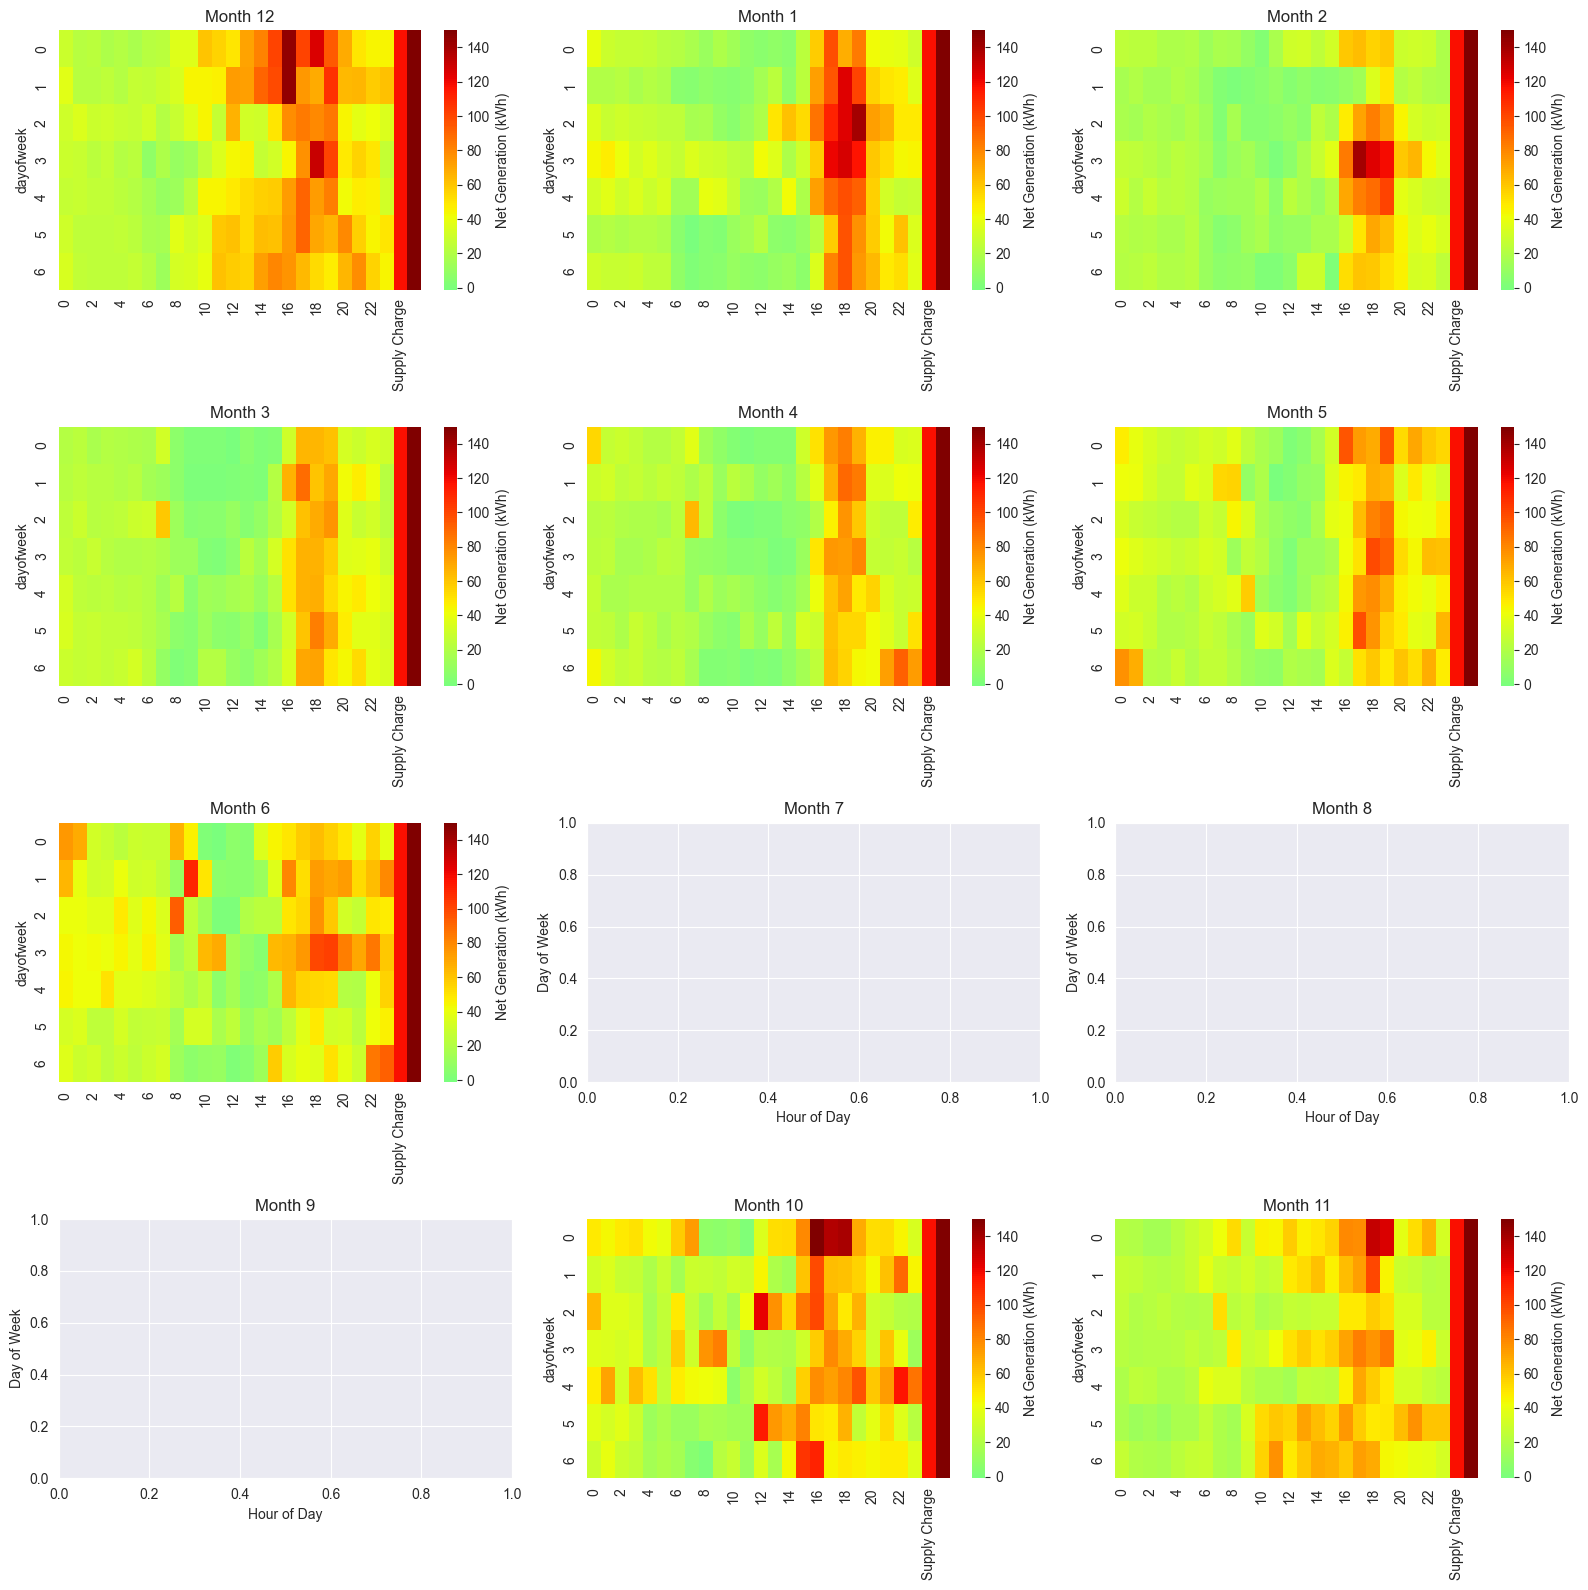

In [71]:

# Example usage of the function
# actual_usage_data = pd.read_csv('path_to_actual_usage.csv')  # load your actual usage data here
# solar_costs_df, variable_costs_df = apply_rates(actual_usage_data, solar_df, variable_df)
# 
# print("Solar Costs DataFrame:")
# print(solar_costs_df.head())
# print("\nVariable Costs DataFrame:")
# print(variable_costs_df.head())

cost, fit, net = calculate_costs(gen_data_hourly, cons_data_hourly, solar_df, tarrif_df, supply_charge)

print(net)
print(net.sum())

# subtract the values in the generation dataframe from the consumption dataframe to get the net consumption. we want to keep all the columns (but no maths on the date-related columns)
# 
# # Selecting only numeric columns (by data type or by column name pattern if consistent)
# meta_cols = ['dayofweek', 'month', 'date', 'Date/Time']
# numeric_cols = cons_data_hourly.columns.difference(meta_cols)
# 
# # Subtract the numeric columns of df2 from df1
# net_data = (cons_data_hourly[numeric_cols] - gen_data_hourly[numeric_cols])
# 
# max_val = net_data.max().max()
# min_val = net_data.min().min()
# 
# print(f'Max Net Consumption: {max_val} kWh')
# print(f'Max Net Generation: {min_val * -1} kWh')
# 
# net_data = net_data[sorted(net_data.columns, key=int)]
# net_data = net_data.join(cons_data_hourly[meta_cols])
monthly_data = {
    month: cost[cost['month'] == month].drop(columns=['date', 'month'])
    .groupby(['dayofweek']).mean()
    for month in range(1, 13)
}

# Plot the data in a 3x4 grid of heatmaps, each row in the grid is a season (Dec-Feb, Mar-May, Jun-Aug, Sep-Nov)
fig, ax = plt.subplots(4, 3, figsize=(16, 16))

plt.title('Average Hourly Net Generation by Day of Week for Each Month')


# Define a season map where keys are month indices (1-12) and values are (row, col) tuples
seasons = [
    (12,1,2),
    (3,4,5),
    (6,7,8),
    (9,10,11)
]

# Dictionary to hold month to (row, col) mappings
season_map = {}
for row, months in enumerate(seasons):
    for col, month in enumerate(months):
        season_map[month] = (row, col)


for month, data in monthly_data.items():

    row, col = season_map[month]

    subplot = ax[row, col]

    subplot.set_title(f'Month {month}')

    subplot.set_xlabel('Hour of Day')
    subplot.set_ylabel('Day of Week')

    if data.empty: continue
    sns.heatmap(data, ax=subplot, cmap='jet', vmax=150, vmin=-1, center=0, cbar_kws={'label': 'Net Generation (kWh)'})

plt.tight_layout()
plt.show()

